<a href="https://colab.research.google.com/github/DimitrisLianos/DL/blob/main/GAN_face_generation_model_with_sentiment_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

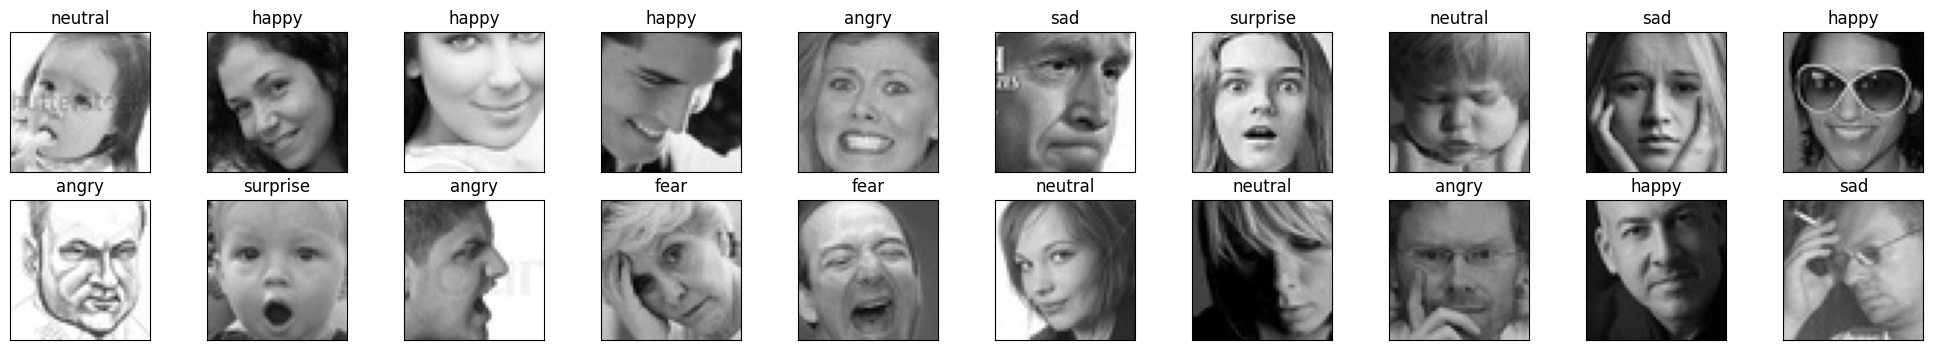

In [61]:
import matplotlib.pyplot as plt
import numpy as np
# Create a reverse dictionary for mapping label numbers to expressions
label_to_expression = {v: k for k, v in dataset.labels_dict.items()}

# Get a batch of images and labels
images, labels = next(iter(dataloader))

# Convert the images for display
images = images.numpy().transpose((0, 2, 3, 1))

# Plot the images
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow((images[idx]+1)/2) # denormalize
    ax.set_title(label_to_expression[int(labels[idx].numpy())])


In [ ]:
# working :)
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import random
from tqdm import tqdm
from torchvision.utils import save_image
from rarfile import RarFile
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Extract .rar file
with RarFile('/content/drive/MyDrive/Colab Notebooks/GAN face generation model with sentiment parameters/train.rar', 'r') as zip_ref:
    zip_ref.extractall('/content/train')

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import random
from torchvision.utils import save_image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Generator and Discriminator classes

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, num_classes):
        super(Generator, self).__init__()

        self.embed = nn.Embedding(num_classes, nz, dtype=torch.float)
        self.fc = nn.Sequential(
            nn.Linear(nz, ngf * 8 * 4 * 4),
            nn.BatchNorm1d(ngf * 8 * 4 * 4),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        embed = self.embed(labels)
        x = torch.mul(noise, embed)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        x = self.deconv(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, nc, ndf, num_classes):
        super(Discriminator, self).__init__()

        self.embed = nn.Embedding(num_classes, ndf * 4 * 4)
        self.conv = nn.Sequential(
            nn.Conv2d(nc + ndf, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input, labels):
        batch_size = input.size(0)
        embed = self.embed(labels).view(batch_size, -1, 4, 4)
        x = torch.cat((input, embed.repeat(1, 1, input.size(2) // 4, input.size(3) // 4)), dim=1)
        x = self.conv(x)
        return x.view(batch_size, -1)


# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

# Set hyperparameters
num_epochs = 100
batch_size = 64
nz = 100  # Noise dimension
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps
nc = 3  # Number of channels in the training images
num_classes = 7  # Number of facial expression classes

# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define custom dataset
class FaceExpressionDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.labels_dict = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}
        self.classes = self.labels_dict.keys()

        self.all_imgs = []
        self.all_labels = []
        for emotion in self.classes:
            emotion_dir = os.path.join(self.main_dir, emotion)
            emotion_imgs = os.listdir(emotion_dir)
            self.all_imgs += [os.path.join(emotion_dir, img) for img in emotion_imgs]
            self.all_labels += [self.labels_dict[emotion]] * len(emotion_imgs)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = self.all_imgs[idx]
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)

        label = self.all_labels[idx]

        return tensor_image, label

# Create the dataset and dataloader
dataset = FaceExpressionDataset("/content/train/train", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize generator and discriminator
generator = Generator(nz, ngf, nc, num_classes).to(device)
discriminator = Discriminator(nc, ndf, num_classes).to(device)

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Set total number of steps
total_step = len(dataloader)

# Initialize tqdm for progress bar
progress_bar = tqdm(total=total_step, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        real_labels = torch.ones(images.size(0)).to(device)
        fake_labels = torch.zeros(images.size(0)).to(device)

        # Train Discriminator
        discriminator.zero_grad()

        # Real images
        real_output = discriminator(images, labels).view(-1)
        d_loss_real = criterion(real_output, real_labels)
        real_score = torch.mean(real_output).item()

        # Fake images
        noise = torch.randn(images.size(0), nz).to(device)
        fake_labels = torch.randint(0, num_classes, (images.size(0),)).long().to(device)
        fake_images = generator(noise, fake_labels)
        fake_output = discriminator(fake_images.detach(), fake_labels).view(-1)
        d_loss_fake = criterion(fake_output, fake_labels.float())
        fake_score = torch.mean(fake_output).item()

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        fake_labels = torch.randint(0, num_classes, (images.size(0),)).long().to(device)
        fake_images = generator(noise, fake_labels)
        fake_output = discriminator(fake_images, fake_labels).view(-1)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Update progress bar
        progress_bar.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}]")
        progress_bar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item(), D_x=real_score, D_G_z=fake_score)
        progress_bar.update()

    # Save generated images
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            noise = torch.randn(25, nz).to(device)
            labels = torch.arange(0, num_classes).repeat(25 // num_classes).to(device)
            fake_images = generator(noise, labels).detach().cpu()
            fake_images = (fake_images + 1) / 2  # Denormalize

            save_image(fake_images, f"generated_images_{epoch + 1}.png", nrow=5)

# Close the progress bar
progress_bar.close()

print("Training complete!")

Epoch [1/100], Step [136/451]:  30%|███       | 136/451 [15:49<37:35,  7.16s/it, D_G_z=0.829, D_loss=-198, D_x=0.996, G_loss=0.956]